In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from torch.utils.data import DataLoader
import numpy as np
import glob as glob
import importlib
import json

import sys
#project_root = Path.cwd().parent  # adjust if llms-entropy isn’t directly under the project root
#sys.path.append(str(project_root / "gpt-circuits"))
sys.path.append('/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/')

import compute

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
importlib.reload(compute)

<module 'compute' from '/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/compute.py'>

In [5]:
# model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B", device_map='cuda')
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B",device_map='cuda')
model = AutoModelForCausalLM.from_pretrained("allenai/OLMo-2-0425-1B", device_map='cuda')
tokenizer = AutoTokenizer.from_pretrained("allenai/OLMo-2-0425-1B",device_map='cuda')
model2 = AutoModelForCausalLM.from_pretrained("openai/gpt-oss-20b", device_map='cuda')
tokenizer2 = AutoTokenizer.from_pretrained("openai/gpt-oss-20b",device_map='cuda')

tokenizer.pad_token=tokenizer.eos_token
tokenizer2.pad_token=tokenizer2.eos_token

Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.96s/it]
MXFP4 quantization requires Triton and kernels installed: CUDA requires Triton >= 3.4.0, XPU requires Triton >= 3.5.0, we will default to dequantizing the model to bf16
Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:27<00:00,  9.00s/it]


In [6]:
files=['/scratch/gpfs/DATASETS/hugging_face/c4/en/c4-train.00217-of-01024.json']

data=[]
for file in files:
    with open(file,'r') as f:
        data+=[json.loads(l) for l in f]


btext=[d['text'] for d in data]

ftext=compute.filterize(btext)

splitlen=15000#args.splitlen
ftext_elongated=[]
for t in ftext:
    ftext_elongated+=[t[i:i+splitlen] for i in np.arange(0,len(t),splitlen)]

lengths=np.array([len(t) for t in ftext_elongated])
indsort=np.flip(np.argsort(lengths))
nsamples=10#args.nsamples
buffer=100#args.buffer
rng=np.random.default_rng(21345)
starts=rng.choice(buffer,size=nsamples)
ftext_sorted=[ftext_elongated[i][s:] for i,s in zip(indsort[:nsamples],starts)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 356317/356317 [00:05<00:00, 70616.53it/s]


In [4]:
#model.config.hidden_size

In [7]:
#perform the analysis 
batchsize=2#args.batchsize
dataloader=DataLoader(ftext_sorted,batch_size=batchsize)


In [8]:
compute.computer(savedir='/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/test_compute_output/',
                 shapecut=2000,
                 dataloader=dataloader,
                 batchsize=batchsize, 
                 model=model, 
                 tokenizer=tokenizer,
                 device=device, 
                 printevery=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


### Checking the outputs

In [9]:
def consolidate(fileformat):
    files = np.array(glob.glob(fileformat))
    numbers=[int(f.split("/")[-1].split(".")[0]) for f in files]
    files=files[np.argsort(numbers)]

    tensors=[]
    for fname in files:
        with open(fname,'rb') as f:
            tensors.append(np.load(f))
    
    return np.vstack(tensors)

def loaddata(loaddir):
    msk=consolidate(loaddir+'attn/*.npy')
    etens=consolidate(loaddir+'entropy/*.npy')
    ctens=consolidate(loaddir+'codelength/*.npy') 
    ptens=consolidate(loaddir+'pleak/*.npy')
    ltens=consolidate(loaddir+'tlens/*.npy')
    ttens=consolidate(loaddir+'tok/*.npy')
    #print(msk)
    nos=msk.sum(axis=0)
    weights=msk/msk.sum(axis=0,keepdims=True)
    eaverage=(etens*weights).sum(axis=0)
    caverage=(ctens*weights[:,:-1]).sum(axis=0)

    return {'e': eaverage,
            'c': caverage,
            'n': nos,
            'p': ptens,
            'l': ltens,
            't': ttens}
    

In [10]:
#data=loaddata('/scratch/gpfs/WINGREEN/cs5096/learning/EntropyLLM/character_experiments/notebookcheckOLMo/')
# data=loaddata('/scratch/gpfs/WINGREEN/cs5096/learning/EntropyLLM/character_experiments/BBCtest/')
data=loaddata('/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/test_compute_output/')

In [11]:
data['t']

array([[  719,  1781,   922, ...,   315,   279,  3363],
       [   68,   279,  1888, ...,  6671,    13,  1283],
       [10118,   292, 18065, ...,  1070,   527, 11510],
       ...,
       [   68, 39322, 74307, ...,   323,   889,   706],
       [ 3479,  1139,   264, ...,   279,  1193, 25835],
       [  346,   315, 15022, ...,   477,   264,  1427]], shape=(10, 2000))

In [12]:
data['l']

array([[ 4,  6,  6, ...,  3,  4,  5],
       [ 1,  4,  5, ..., 10,  1,  3],
       [ 3,  2,  9, ...,  6,  4,  7],
       ...,
       [ 1,  4,  3, ...,  4,  4,  4],
       [ 4,  5,  2, ...,  4,  5, 11],
       [ 2,  3, 12, ...,  3,  2,  5]], shape=(10, 2000))

In [13]:
#tokenizer.decode(988)

(-0.01, 1.01)

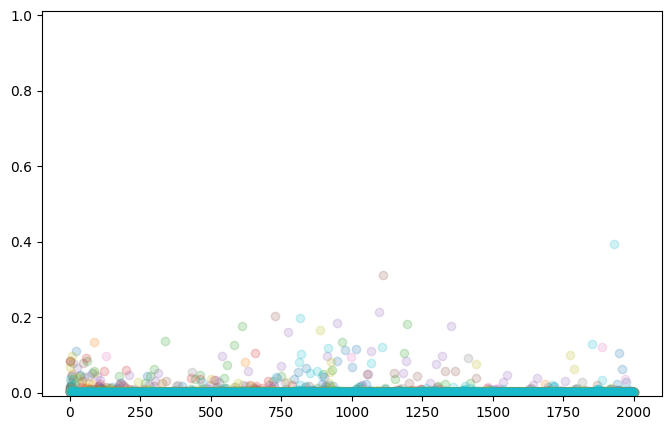

In [14]:
fig,ax=plt.subplots(figsize=(8,5),dpi=100)

xvs=np.arange(data['p'].shape[-1])+1
for d in data['p']:
    ax.scatter(xvs,1-d,alpha=0.2)

ax.set_ylim([-0.01,1.01])
#ax.set_yscale('log')

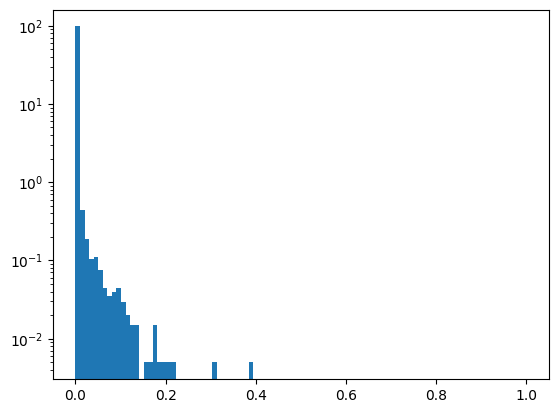

In [15]:
plt.hist(1-data['p'].flatten(),bins=np.linspace(0,1,100),density=True)
plt.yscale('log')

Text(0, 0.5, 'Entropy of next-character (bits)')

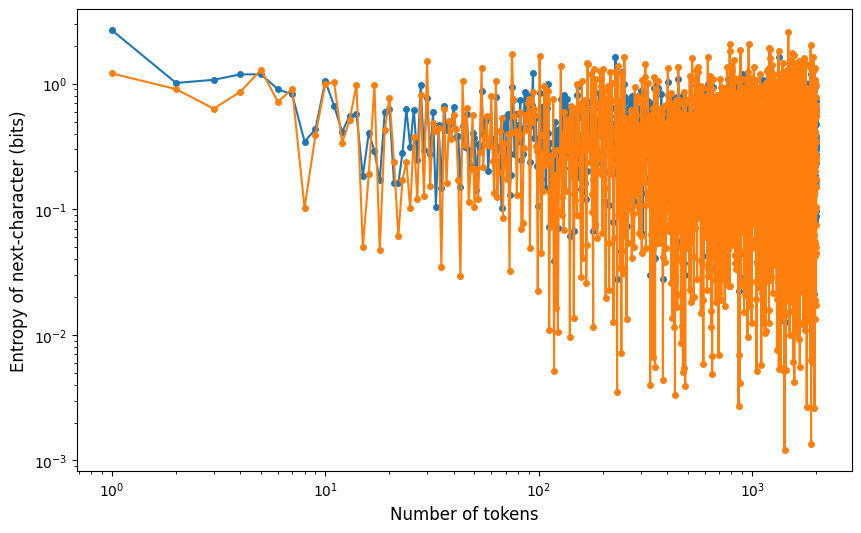

In [16]:
fig,ax=plt.subplots(figsize=(10,6),dpi=100)

xvs=np.arange(len(data['e']))
ax.plot(xvs+1,data['e'],marker='o',ms=4)

xvs=np.arange(len(data['c']))
ax.plot(xvs+1,data['c'],marker='o',ms=4)

#ax.legend(frameon=False, fontsize=12,bbox_to_anchor=(1.0,0.5),loc='center left')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Number of tokens",fontsize=12)
ax.set_ylabel('Entropy of next-character (bits)',fontsize=12)

In [18]:
compute.computer(savedir='/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/test_compute_output/gpt/',
                 shapecut=2000,
                 dataloader=dataloader,
                 batchsize=batchsize, 
                 model=model2, 
                 tokenizer=tokenizer2,
                 device=device, 
                 printevery=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.75s/it]


In [19]:
data=loaddata('/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/test_compute_output/gpt/')

In [20]:
data['t']

array([[   889,   2411,   1078, ...,    306,  11967,    485],
       [    68,    290,   1636, ...,   8789,     13,   1679],
       [  9737,    291,  23856, ...,    481,    679,    316],
       ...,
       [    68, 136743,    261, ...,     11,    581,    679],
       [ 16366,   1511,    261, ...,     11,    290,   1606],
       [   400,    328,  18602, ...,  12106,  29723,     13]],
      shape=(10, 2000))

In [21]:
data['l']

array([[ 4,  6,  6, ...,  3,  7,  2],
       [ 1,  4,  5, ..., 10,  1,  3],
       [ 3,  2,  9, ...,  4,  5,  3],
       ...,
       [ 1,  7,  2, ...,  1,  3,  5],
       [ 4,  5,  2, ...,  1,  4,  5],
       [ 2,  3, 12, ...,  7, 12,  1]], shape=(10, 2000))

(-0.01, 1.01)

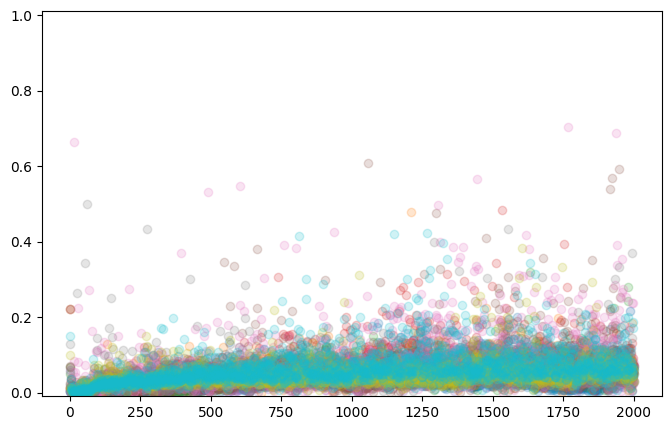

In [22]:
fig,ax=plt.subplots(figsize=(8,5),dpi=100)

xvs=np.arange(data['p'].shape[-1])+1
for d in data['p']:
    ax.scatter(xvs,1-d,alpha=0.2)

ax.set_ylim([-0.01,1.01])
#ax.set_yscale('log')

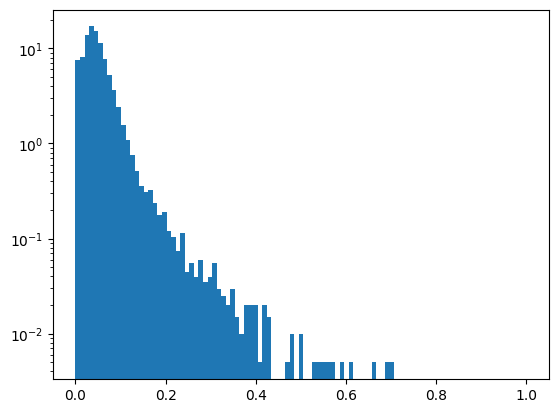

In [23]:
plt.hist(1-data['p'].flatten(),bins=np.linspace(0,1,100),density=True)
plt.yscale('log')

Text(0, 0.5, 'Entropy of next-character (bits)')

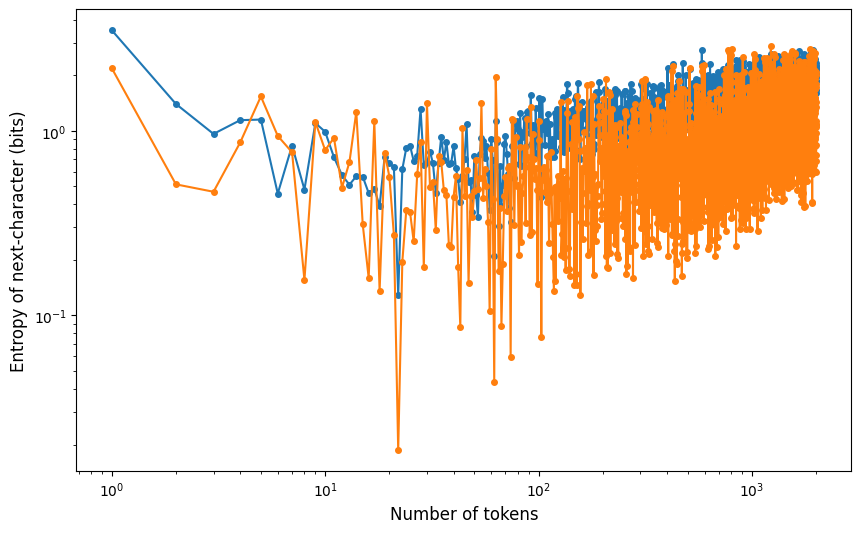

In [24]:
fig,ax=plt.subplots(figsize=(10,6),dpi=100)

xvs=np.arange(len(data['e']))
ax.plot(xvs+1,data['e'],marker='o',ms=4)

xvs=np.arange(len(data['c']))
ax.plot(xvs+1,data['c'],marker='o',ms=4)

#ax.legend(frameon=False, fontsize=12,bbox_to_anchor=(1.0,0.5),loc='center left')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Number of tokens",fontsize=12)
ax.set_ylabel('Entropy of next-character (bits)',fontsize=12)

In [ ]:
# test on bbc data
